In [17]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

Epoch 1/50
235/235 [==============================] - 2s 9ms/step - loss: 0.2924 - val_loss: 0.2122
Epoch 2/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1975 - val_loss: 0.1860
Epoch 3/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1786 - val_loss: 0.1706
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1684 - val_loss: 0.1639
Epoch 5/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1625 - val_loss: 0.1588
Epoch 6/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1581 - val_loss: 0.1556
Epoch 7/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1557 - val_loss: 0.1538
Epoch 8/50
235/235 [==============================] - 2s 8ms/step - loss: 0.1539 - val_loss: 0.1521
Epoch 9/50
235/235 [==============================] - 2s 9ms/step - loss: 0.1526 - val_loss: 0.1508
Epoch 10/50
235/235 [==============================] - 3s 11ms/step - loss: 0.1515 - val_loss: 0.1

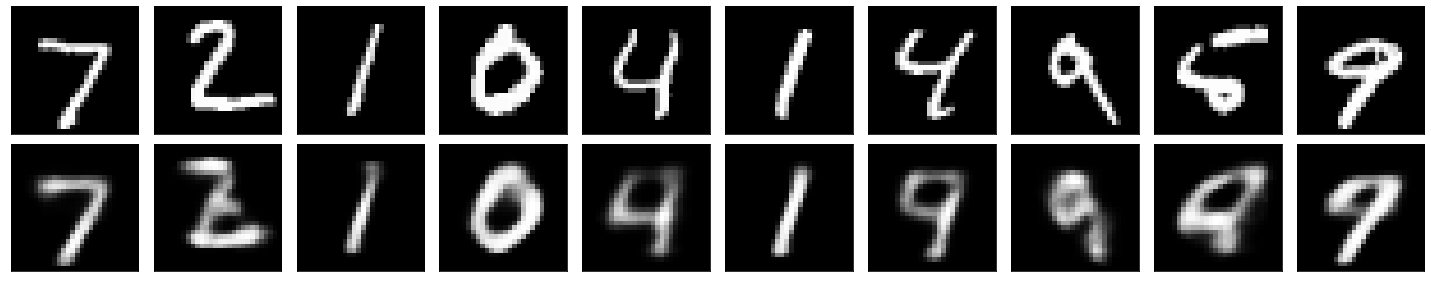

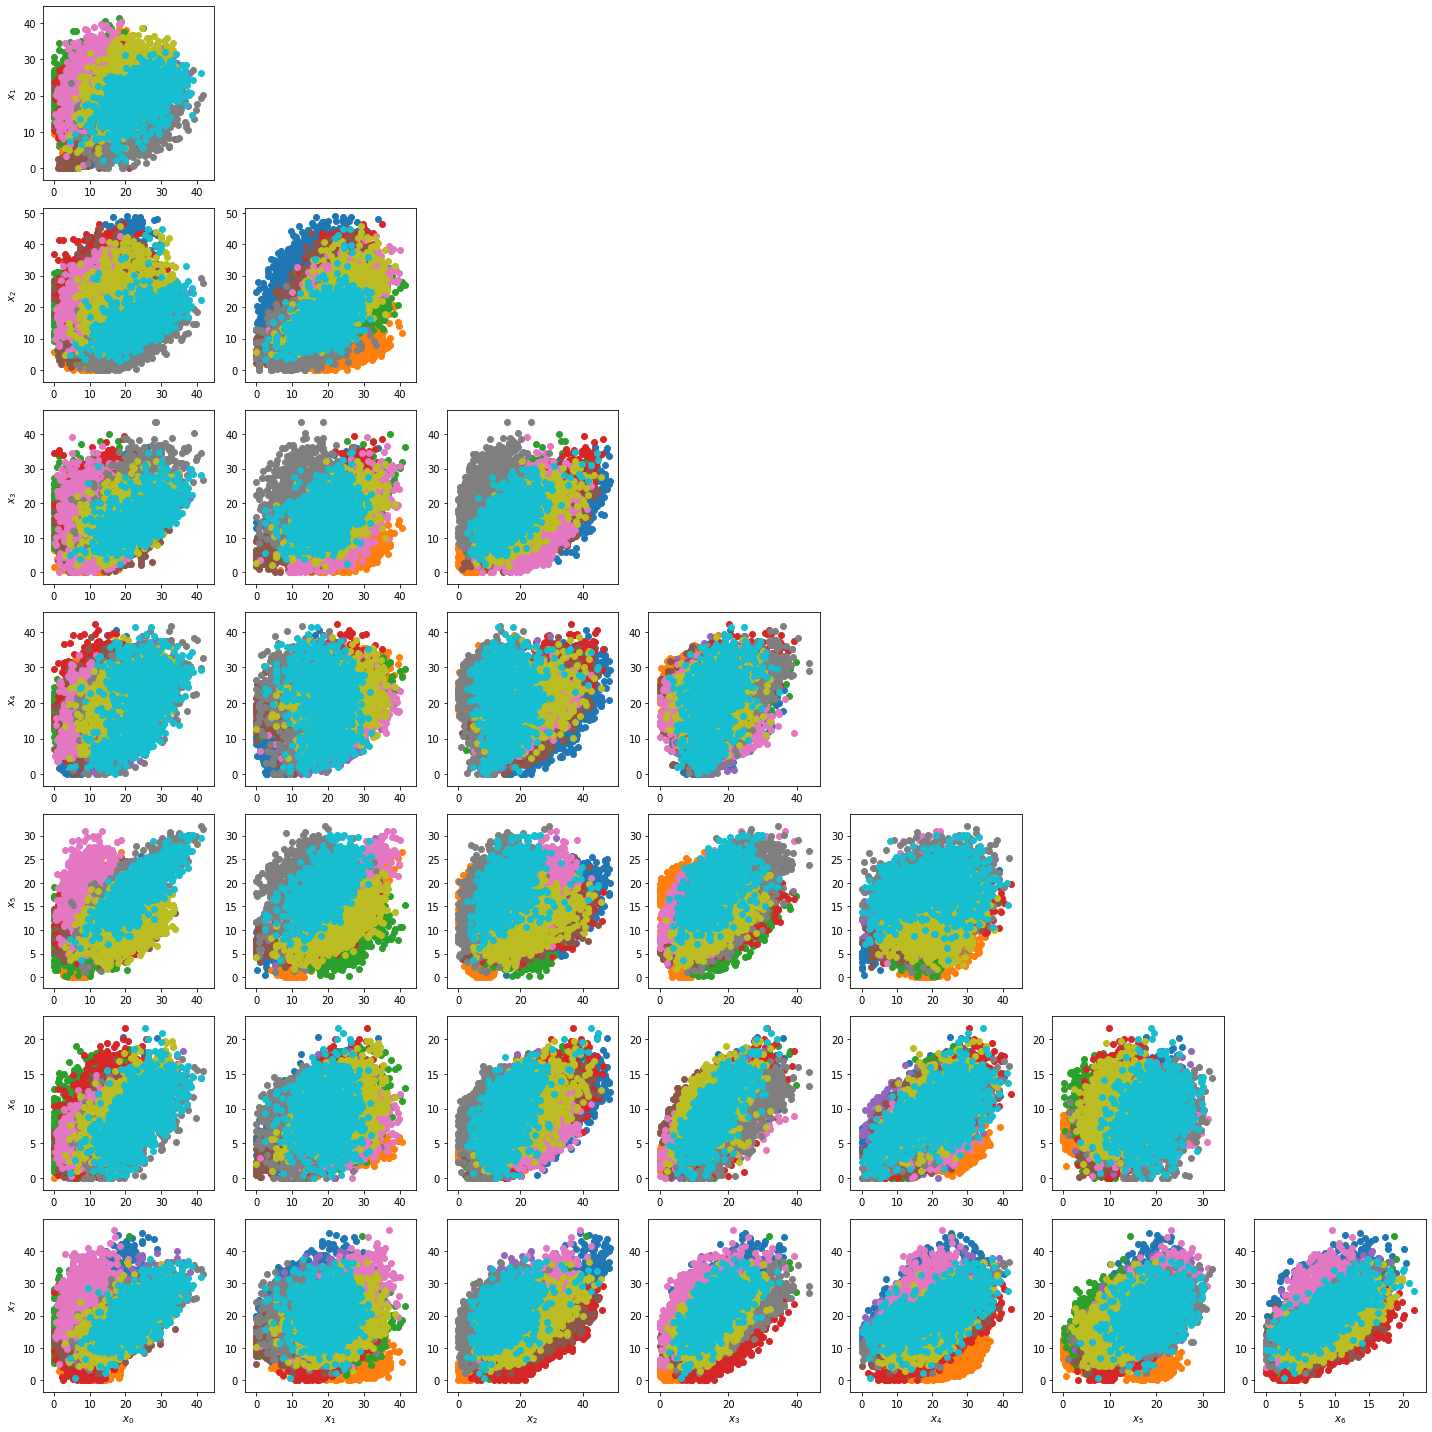

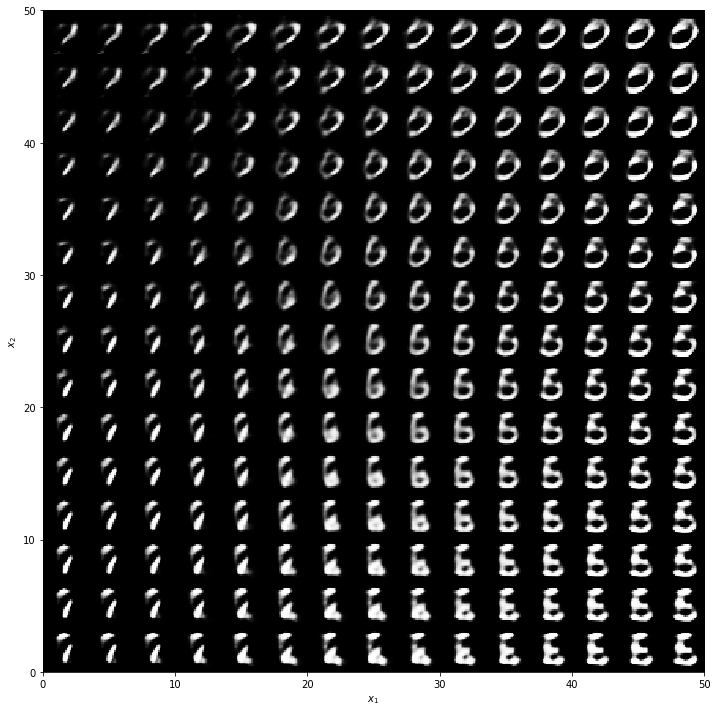

In [19]:
tf.random.set_seed(1)


# training/test set size
n_train = 60000
n_test = 10000


# get data function
def get_data(fname):
    image_size = 28
    f = gzip.open(fname, 'r')
    f.read(16)
    data = f.read()
    data = np.frombuffer(data, dtype=np.uint8).astype(np.float32)
    data = data.reshape(-1, image_size, image_size)
    f.close()
    return data


# get labels function
def get_labels(fname):
    f = gzip.open(fname, 'r')
    f.read(8)
    data = f.read()
    data = np.frombuffer(data, dtype=np.uint8)
    f.close()
    return data


# get data
train_data = get_data('train-images-idx3-ubyte.gz')
test_data = get_data('t10k-images-idx3-ubyte.gz')
labels = get_labels('t10k-labels-idx1-ubyte.gz')


# specify network
input_img = keras.Input(shape=(28*28,))

h_size = 32
latent_size = 8

h1 = layers.Dense(h_size, activation='relu')(input_img)
encoded = layers.Dense(latent_size, activation='relu')(h1)

h2 = layers.Dense(h_size, activation='relu')(encoded)
decoded = layers.Dense(28*28, activation='sigmoid')(h2)

autoencoder = keras.Model(input_img, decoded)

# just the encoder part
encoder = keras.Model(input_img, encoded)

# just the decoder part
encoded_input = keras.Input(shape=(latent_size,))
h2_layer = autoencoder.layers[-2](encoded_input)
decoder_layer = autoencoder.layers[-1](h2_layer)
decoder = keras.Model(encoded_input, decoder_layer)


# compile network
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# normalise and flatten data
train_data = (train_data/255).reshape((-1, 28*28))
test_data = (test_data/255).reshape((-1, 28*28))


# training
autoencoder.fit(train_data, train_data,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(test_data, test_data))


# make predictions
encoded_imgs = encoder.predict(test_data)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig('ae_predictions.png', dpi=300)


# show latent space
x_arr = np.arange(8)
y_arr = np.arange(2, 4)
mesh = np.array(np.meshgrid(x_arr, y_arr))
combinations = mesh.T.reshape(-1, 2)

arrs = encoded_imgs.T
fig, axs = plt.subplots(7, 7, figsize=(20, 20))
for i in range(8):
    for j in range(7):
        ax = axs[i-1, j]
        if (j >= i):
            ax.axis('off')
            continue
        ax.axis('on')
        x = arrs[j]
        y = arrs[i]
        for n in range(10):
            k = np.where(labels == n)
            ax.scatter(x[k], y[k], label=n)
        if i == 7:
            ax.set_xlabel(rf"$x_{j}$")
        if j == 0:
            ax.set_ylabel(rf"$x_{i}$")

plt.tight_layout()
plt.savefig('latent_space.png', dpi=300)


# Save models
autoencoder.save('autoencoder')
encoder.save('encoder')
decoder.save('decoder')


# part 2

# number of images = nx * ny
nx = 15
ny = 15
# how much of latent space we will plot
x_min = 0
x_max = 50
y_min = 0
y_max = 50

xs = np.linspace(x_min, x_max, nx)
ys = np.linspace(x_min, x_max, ny)

# will plot how these change
x1, x2 = np.meshgrid(xs, ys)
shape = x1.shape

# get constant values for each other node
x0 = np.full(shape, 10)
x3 = np.full(shape, 20)
x4 = np.full(shape, 20)
x5 = np.full(shape, 20)
x6 = np.full(shape, 10)
x7 = np.full(shape, 20)

full_grid = np.stack((x0, x1, x2, x3, x4, x5, x6, x7)).T

# reshape into big combined picture
full_grid = full_grid.reshape(nx*ny, 8)
decoded_grid = decoder.predict(full_grid)
decoded_grid = decoded_grid.reshape((nx, ny, 28, 28))
decoded_grid = decoded_grid.swapaxes(1, 2)
decoded_grid = decoded_grid.reshape(28*nx, 28*ny)

fig, ax = plt.subplots(figsize=(10, 10))
extent = [x_min, x_max, y_min, y_max]
ax.imshow(decoded_grid, extent=extent)
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
plt.tight_layout()
plt.savefig('image_grid.png', dpi=300)



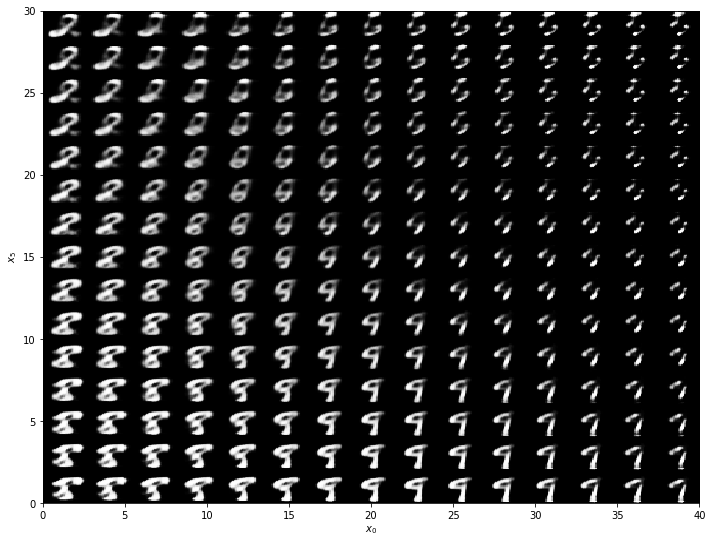

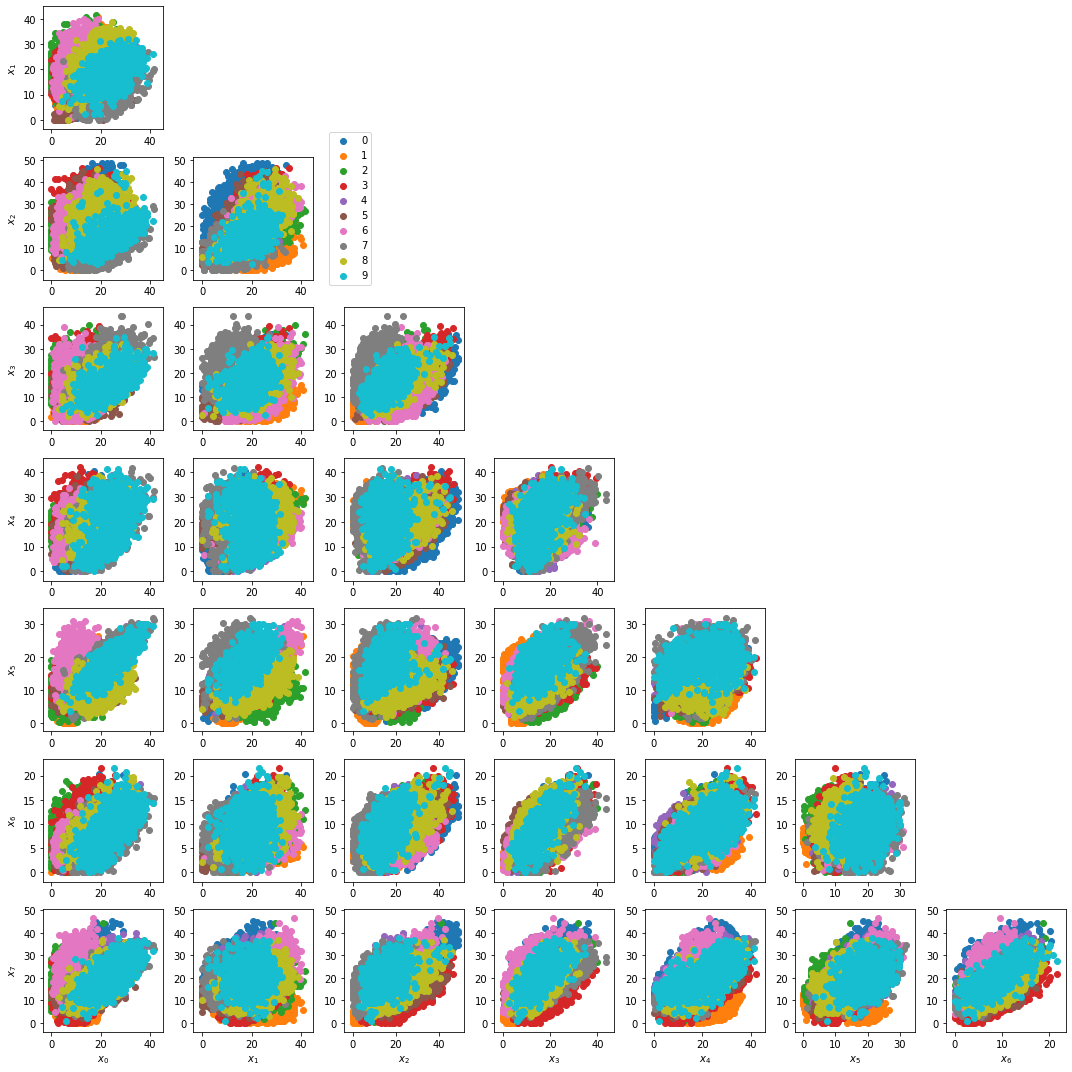

In [51]:
arrs = encoded_imgs.T
fig, axs = plt.subplots(7, 7, figsize=(15, 15))
label = False
for i in range(8):
    for j in range(7):
        ax = axs[i-1, j]
        if (j >= i):
            ax.axis('off')
            continue
        ax.axis('on')
        x = arrs[j]
        y = arrs[i]
        for n in range(10):
            k = np.where(labels == n)
            if not label:
                ax.scatter(x[k], y[k], label=n)
            else:
                ax.scatter(x[k], y[k])
        label = True
        if i == 7:
            ax.set_xlabel(rf"$x_{j}$")
        if j == 0:
            ax.set_ylabel(rf"$x_{i}$")
fig.legend(loc='center left', bbox_to_anchor=(0.3,0.8))
plt.tight_layout()
plt.show()